# Install dependencies

In [ ]:
!pip install karateclub
!pip install node2vec
!pip install dgl
!pip install networkx==2.8.4
!pip install adjustText

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import dgl
from dgl.nn import GraphConv
import math
import time
from tqdm import tqdm
import copy
from collections import Counter
from __future__ import division
from __future__ import print_function
from dgl.nn import SAGEConv
import sklearn.linear_model as lm
import sklearn.metrics as skm
import itertools
import scipy.sparse as sp
import dgl.function as fn
from sklearn.metrics import roc_auc_score
import torch
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from dgl.dataloading import GraphDataLoader

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Import graphs merged CSV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels_path='/content/drive/MyDrive/AI_graph/Organized_Dataset02/MergedGraphData/merged05.csv'
graphs_labels=pd.read_csv(labels_path , header = 0)
#graphs_labels.columns = ['PLanQualt']
graphs_labels

,PlanQualt,PlanEff,PlanArea
0,0.821710,4,369.821362
1,0.863134,4,484.369032
2,0.938339,4,510.930180
3,0.933211,4,636.809599
4,0.822473,4,846.596397
...,...,...,...
4459,1.077613,4,477.061939
4460,1.037720,4,508.334687
4461,1.222545,4,634.084150
4462,0.893279,4,843.528495


In [ ]:
graphs_labels.describe()

,PlanQualt,PlanEff,PlanArea
count,4464.000000,4464.0,4464.000000
mean,0.994728,4.0,630.189040
std,0.160874,0.0,210.301364
min,0.530967,4.0,244.052855
25%,0.879459,4.0,478.446973
50%,0.998720,4.0,567.982768
75%,1.115389,4.0,843.762609
max,1.320899,4.0,963.528706


# convert graphs continous scores into categorical scores

In [ ]:
encoded_graph_labels=[]
for i in graphs_labels.values:
  #print(i[0]) # each value is in a single list
  if i[0] < 0.8:
    encoded_graph_labels.append(0)
  elif i[0] >=0.8 and i[0] < 1:
    encoded_graph_labels.append(1)
  elif i[0] >=1 and i[0] < 1.2:
    encoded_graph_labels.append(2)
  elif i[0] >=1.2 :
    encoded_graph_labels.append(3)

In [ ]:
# graphs_labels['encoded_graph_labels']=encoded_graph_labels
# graphs_labels
encoded_graph_labels

In [ ]:
graphs_labels['encoded_graph_labels']=encoded_graph_labels
graphs_labels
graphs_labels = graphs_labels.drop(["PlanEff","PlanArea"], axis=1)

In [ ]:
graphs_labels

,PlanQualt,encoded_graph_labels
0,0.821710,1
1,0.863134,1
2,0.938339,1
3,0.933211,1
4,0.822473,1
...,...,...
4459,1.077613,2
4460,1.037720,2
4461,1.222545,3
4462,0.893279,1


# Visualize categories distribution

In [ ]:
import pandas as pd
import seaborn as sns
import altair as alt

sns.set(rc={'figure.figsize':(10,10)})
print("imports ok")

imports ok


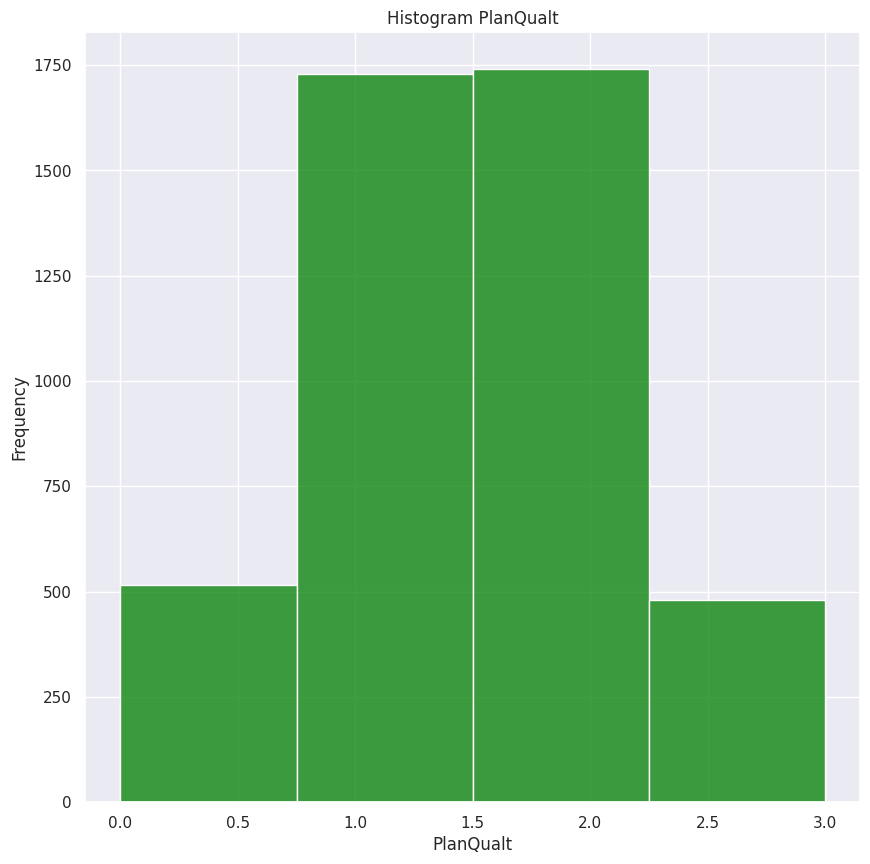

In [ ]:
sns.histplot(graphs_labels["encoded_graph_labels"], bins=4, color="Green")
plt.title("Histogram PlanQualt")
plt.xlabel("PlanQualt")
plt.ylabel("Frequency")
plt.show()

# Drop extra values to have uniform dataset distribution

In [ ]:
import pandas as pd

# Create an empty list to store the dropped row indices
dropped_indices = []

# Create an empty dictionary to store the count of samples per category
category_counts = {0: 0, 1: 0, 2: 0, 3: 0}

# Define the maximum number of samples per category
max_samples_per_category = 475

# Iterate through the original dataset line by line
for index, row in graphs_labels.iterrows():
    # Get the category value for the current row
    category = row['encoded_graph_labels']

    # Check if the category count has reached the maximum number of samples
    if category_counts[category] >= max_samples_per_category:
        # Store the index of the dropped row
        dropped_indices.append(index)
    else:
        # Increment the count of samples for the current category
        category_counts[category] += 1

# Create the final dataset by dropping the rows with dropped indices
final_dataset = graphs_labels.drop(dropped_indices)


In [ ]:
print(len(final_dataset))

1900


In [ ]:
print(len(dropped_indices))

2564


In [ ]:
final_dataset.head(50)

In [ ]:
indices = final_dataset.index

In [ ]:
index_list = indices.tolist()

In [ ]:
index_list

In [ ]:
last_20_items = index_list[-100:]
last_20_items

In [ ]:
index_list_RN = [index + 1 for index in index_list]
index_list_RN

In [ ]:
# last_20_items_RN = index_list_RN[-100:]
last_20_items_RN

# Select the corresponding node and edgelist to the selected graphs

In [ ]:

import shutil
import os
# Set the path of the original folder in Google Drive
original_folder_path = '/content/drive/MyDrive/AI_graph/Organized_Dataset02/Collective_Dataset'

# Set the path of the destination folder in Google Drive
destination_folder_path = '/content/drive/MyDrive/AI_graph/Organized_Dataset02/CDS_U06'

# # Add 1 to each item in index_list list
# index_list = [index + 1 for index in index_list]

# Get the list of files in the original folder
file_list = os.listdir(original_folder_path)

# Sort the data
file_list.sort()
# Iterate over the files in the original folder
for file_name in file_list:
    # Extract the number from the file name
    number = int(file_name.split('_')[0])

    # Check if the number is in the index_list list
    if number in index_list_RN:
        # Copy the file to the destination folder
        file_path = os.path.join(original_folder_path, file_name)
        destination_path = os.path.join(destination_folder_path, file_name)
        shutil.copyfile(file_path, destination_path)


# Rename the selected files " nodes and edges "

In [ ]:
import os
import shutil

# Set the path to the second folder
second_folder_path = '/content/drive/MyDrive/AI_graph/Organized_Dataset02/CDS_U06'

# Get a list of all the files in the second folder
files = os.listdir(second_folder_path)

# Select only files that contain the name "edge"
files = [file for file in files if "node" in file]

# Sort the files based on the numeric part of their names
files.sort(key=lambda x: int(x.split("_")[0]))

# Rename and copy each file to a new location
for i, file in enumerate(files):
    new_name = '{}_nodelist.csv'.format(i+1)
    shutil.copyfile(os.path.join(second_folder_path, file), os.path.join('/content/drive/MyDrive/AI_graph/Organized_Dataset02/CDS_U06_R', new_name))

print("Done!")


Done!


In [ ]:
import os
import shutil

# Set the path to the second folder
second_folder_path = '/content/drive/MyDrive/AI_graph/Organized_Dataset02/CDS_U06'

# Get a list of all the files in the second folder
files = os.listdir(second_folder_path)

# Select only files that contain the name "edge"
files = [file for file in files if "edge" in file]

# Sort the files based on the numeric part of their names
files.sort(key=lambda x: int(x.split("_")[0]))

# Rename and copy each file to a new location
for i, file in enumerate(files):
    new_name = '{}_edgelist.csv'.format(i+1)
    shutil.copyfile(os.path.join(second_folder_path, file), os.path.join('/content/drive/MyDrive/AI_graph/Organized_Dataset02/CDS_U06_R', new_name))

print("Done!")


Done!


# Save new graph dataset to CSV

In [ ]:
final_dataset

,PlanQualt,encoded_graph_labels
0,0.821710,1
1,0.863134,1
2,0.938339,1
3,0.933211,1
4,0.822473,1
...,...,...
4365,1.230991,3
4369,1.282888,3
4370,1.224987,3
4404,1.273345,3


In [ ]:
Uniform_graph_dataset = final_dataset.reset_index(drop=True)

In [ ]:
Uniform_graph_dataset

,PlanQualt,encoded_graph_labels
0,0.821710,1
1,0.863134,1
2,0.938339,1
3,0.933211,1
4,0.822473,1
...,...,...
1895,1.230991,3
1896,1.282888,3
1897,1.224987,3
1898,1.273345,3


In [ ]:
!pip install --upgrade pandas
# Define the path to the Google Drive folder
folder_path = '/content/drive/MyDrive/AI_graph/Organized_Dataset02/MergedGraphData'

# Save the DataFrame as a CSV file in the Google Drive folder
final_dataset.to_csv(folder_path + '/Uniform_graph_dataset_U01.csv', index=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 58.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.2 which is incompatible.
karateclub 1.3.3 requires networkx<2.7, but you have networkx 2.8.4 which is incompatible.
karateclub 1.3.3 requires pandas<=1.3.5, but you have pandas 2.0.2 which is incompatible.
